In [1]:
import os

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [2]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [3]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))


class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

In [4]:
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()


class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)


class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)


class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [5]:
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

In [6]:
for i, act_fn_name in enumerate(act_fn_by_name):
    act_fn = act_fn_by_name[act_fn_name]()
    print(act_fn)
    

Sigmoid()
Tanh()
ReLU()
LeakyReLU()
ELU()
Swish()


In [7]:
class LitMNIST(L.LightningModule):
    def __init__(self, act_fn, batch_size, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            act_fn,
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            act_fn,
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [8]:
model_MNIST = LitMNIST(act_fn=Tanh(), batch_size=BATCH_SIZE)
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model_MNIST)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/torch/functional.py:791: UserWarning: The operator 'aten::_unique2' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  output, inverse_indices, counts = torch._unique2(
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The data

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [11]:
trainer.test(model=model_MNIST)

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9452000260353088     │
│         test_loss         │    0.1849779337644577     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1849779337644577, 'test_acc': 0.9452000260353088}]

,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.311156,0.9142,NaN,NaN
1,0.229576,0.9336,NaN,NaN
2,0.189684,0.9448,NaN,NaN
3,NaN,NaN,0.184978,0.9452
3,NaN,NaN,0.184978,0.9452


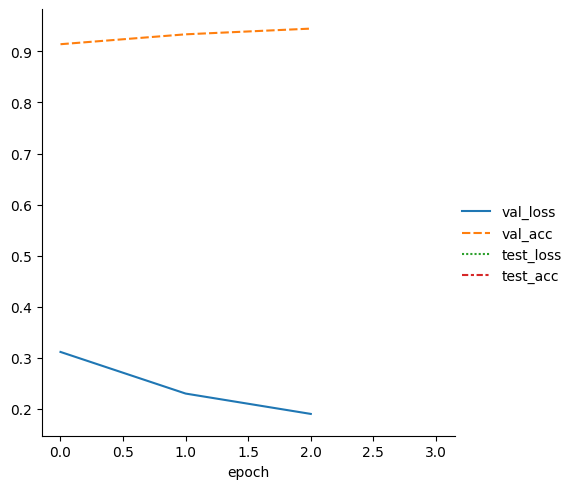

In [12]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")